Several branches corresponding to different models are created on the following github page:
https://github.com/kcirtap2014/question_categorizer

This branch is different in the corpus creation, we create the corpus out of the tags in the train set. 
Only from train set because otherwise we would have commited some data leakage.

In [1]:
import os
import pandas as pd
import seaborn as sns
import string
import re
from collections import defaultdict
from helper_functions import (group_sort, unique_values, freq_stats_corpora, 
                              evaluate, ngram, jaccard_distance, 
                              cosine_similarity, check_similar_tags, 
                              get_best_tags, CrossValidation, rpc_score, H_entropy)


sns.set_style("white")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Mission
Développer un système de suggestion de tag pour le site stackoverflow

# Load Data

In [2]:
cur_dir = os.path.dirname(os.getcwd())
num_db = 6
df = pd.DataFrame([])

for i in range(num_db):
    df = df.append(
        pd.read_csv(
            cur_dir + "/db/QueryResults%d.csv" % (i + 1), index_col=0))

In [3]:
df.shape

(300000, 21)

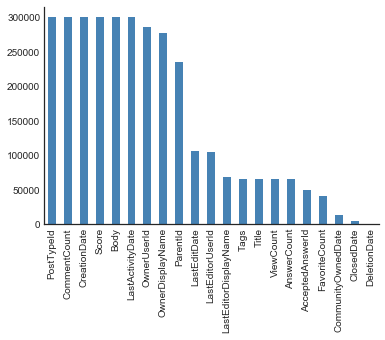

In [4]:
df_count = df.count().sort_values(ascending=False)
fig, ax = plt.subplots()
df_count.plot.bar(color="steelblue", ax=ax)
sns.despine()

In [5]:
df_reduced = df.sample(50000, random_state=23)

__Observation__:
- Each post has an id, PostTypeId, CommentCount, CreationDate, Score and LastActivityDate
- User information are given by OwnerUserId and OwnerDisplayName, almost all posts are given by distinct user.
- Tags have a significant missing values -> users do not tag much

Here, we are interested in analysing the title and body and then suggest tags to users.

In the *unsupervised learning*, tags are not necessary, but in *supervised learning*, tags are the target variable.

In [6]:
# Combine columns
# add an empty space for distinction
df_text = pd.DataFrame(list(zip(df_reduced.Title,
                                df_reduced.Body)), index = df_reduced.index).rename(columns={
                                    0: 'TITLE',
                                    1: 'BODY',
                                })

In [7]:
def stringbetweencode(data):
    p = re.compile("<code>(.+?)<\/code>", flags=re.DOTALL)
    return p.findall(data) 

def tag_between_brackets(data):
    if pd.notnull(data):
        p = re.compile(r'<(.*?)>')
        return p.findall(data)
    return data

#df_text["CODE"] = np.nan
df_text["CODE"] = df_text["BODY"].apply(stringbetweencode) 
df_text["TAGS"] = df_reduced["Tags"].apply(tag_between_brackets) 

# EDA for Tags

## Tags frequencies analysis

In [8]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize

df_tags = df_text[df_text.TAGS.notnull()]["TAGS"]

# combine all tokens together for freq dist
tagslist = df_tags.sum()

# count frequency of each tag
# How many documents are tagged with a specific tag?
tagsfreq = FreqDist(tagslist)

In [9]:
from operator import itemgetter
# sort by values in descending order
sorted_tagsfreq = sorted(tagsfreq.items(), key=itemgetter(1), reverse=True)
tags_key, tags_value = zip(*sorted_tagsfreq)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


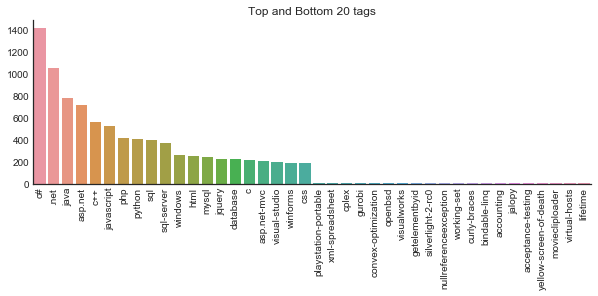

In [10]:
# prepare for sns.barplot
fig, ax = plt.subplots( figsize=(10, 3))

n_element = 20
x_tags = np.array(tags_key[:n_element]+ tags_key[-n_element:])
y_tags = np.array(tags_value[:n_element]+ tags_value[-n_element:])
sns.barplot(x_tags, y_tags, ax=ax)
ax.set_xticklabels(x_tags, rotation=90)
ax.set_title('Top and Bottom 20 tags')
sns.despine()

In [11]:
pd.Series(tags_value).describe([0.5, 0.75,0.9,0.95])

count    4476.000000
mean        7.005585
std        38.234422
min         1.000000
50%         1.000000
75%         4.000000
90%        10.000000
95%        22.000000
max      1409.000000
dtype: float64

__Observation__:
- 50% of the tags only occur once, we will eliminate tags that have low counts, taking the arg of 75% as threshold

# Text preprocessing with scikit learn and NLTK

In [12]:
from sklearn.decomposition import LatentDirichletAllocation
from nltk import regexp_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pdb

wnl = WordNetLemmatizer()


def convert_tag(tag):
    """
    Convert the tag given by nltk.pos_tag 
    to the tag used by wordnet.synsets
    """
    tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
    try:
        return tag_dict[tag[0]]
    except KeyError:
        # defalut value
        return 'n'  #None


def lemmatizer(doc):
    """
    returns lemmatized tokens after removing stop words and pos tagging
    
    Parameters:
    -----------
    doc: pandas dataframe
        text description in df
    
    Return:
    -------
    pandas dataframe
        lemmatized, pos_tagged, and removed stopwords tokens
    """
    if pd.notnull(doc):
        # add words to stoplist, previously punctuations have been removed,
        # so we should do the same for the stoplist
        # we also add the top 10 words in the stoplist, these top 10 words
        # are found after post-processing

        stoplist = [striphtmlpunct(x)
                    for x in stopwords.words('english')] + ['im', 'ive'] + [
                        'use', 'get', 'like', 'file', 'would', 'way', 'code',
                        'work', 'want', 'need'
                    ]

        lemmatized = []

        regex_tokens = regexp_tokenize(doc, pattern='\w+\S+|\.\w+')
        
        for word in regex_tokens:
        #for word, p_tags in pos_tag(regex_tokens):
            #convert_pos_tag = convert_tag(p_tags)
            lemmatized_word = wnl.lemmatize(word)
            if lemmatized_word not in set(stoplist):
                lemmatized.append(lemmatized_word)

        return pd.Series(' '.join(lemmatized))
    return pd.Series(doc)

def postagged(data):
    convert_pos_tag = []
    
    if pd.notnull(data):
        tokens = regexp_tokenize(data, pattern='\w+\S+|\.\w+')
       
        for word, p_tags in pos_tag(tokens):
            convert_pos_tag.append(convert_tag(p_tags))
    return convert_pos_tag

    
def striphtmlpunct(data):
    # remove html tags, code unnecessary punctuations
    # <.*?> to remove everything between <>
    # [^\w\s+\.\-\#\+] remove punctuations except .-#+
    # (\.{1,3})(?!\S) negative lookahead assertion: only match .{1,3} that
    # is followed by white space
    if pd.notnull(data):
        p = re.compile(r'<.*?>|[^\w\s+\.\-\#\+]')
        res = p.sub('', data)
        pe = re.compile('(\.{1,3})(?!\S)')

        return pe.sub('', res)

    return data


def striptabs(data):
    # remove tabs breaklines
    p = re.compile(r'(\r\n)+|\r+|\n+|\t+/i')
    return p.sub(' ', data)


def lower(data):
    if pd.notnull(data):
        return data.lower()
    return data


# remove html tags
df_text["BODY_STRIPPED"] = df_text.BODY.apply(lower).apply(
    striphtmlpunct).apply(striptabs)
df_text["CODE_STRIPPED"] = df_text.CODE.apply(
    lambda x: [striptabs(line.lower()) for line in x if x])
df_text["TITLE_STRIPPED"] = df_text.TITLE.apply(lower).apply(striphtmlpunct)

# remove stop words, pos_tag, and lemmatize
df_text["BODY_LEMMATIZED"] = df_text["BODY_STRIPPED"].apply(lemmatizer)
df_text["TITLE_LEMMATIZED"] = df_text["TITLE_STRIPPED"].apply(lemmatizer)

# postagged column for EDA
df_text["BODY_POSTAGGED"] = df_text["BODY_STRIPPED"].apply(postagged)
df_text["TITLE_POSTAGGED"] = df_text["TITLE_STRIPPED"].apply(postagged)

In [13]:
df_text.head()

,TITLE,BODY,CODE,TAGS,BODY_STRIPPED,CODE_STRIPPED,TITLE_STRIPPED,BODY_LEMMATIZED,TITLE_LEMMATIZED,BODY_POSTAGGED,TITLE_POSTAGGED
Id,,,,,,,,,,,
401982,NaN,<h2>Re Is cut-and-past ever acceptable:</h2>\n...,[private static final String EMPLOYEE_COLUMNS ...,NaN,re is cut-and-past ever acceptable yes when th...,[private static final string employee_columns ...,NaN,cut-and-past ever acceptable yes segment sligh...,NaN,"[n, v, a, r, a, n, n, n, n, v, r, a, n, n, v, ...",[]
109829,NaN,<p>You need to start further down the line. Yo...,[],NaN,you need to start further down the line you ne...,[],NaN,start line know container format specifies cod...,NaN,"[n, v, n, v, r, r, n, n, n, v, n, v, n, n, n, ...",[]
552890,What do you think about the new Debian release...,<p>I was surprised to know that Lenny already ...,[],"[linux, unix, debian, release-cycle]",i was surprised to know that lenny already pro...,[],what do you think about the new debian release...,wa surprised know lenny already promoted stabl...,think new debian release cycle,"[v, v, n, v, n, a, r, v, n, v, n, n, n, n, n, ...","[n, v, n, v, n, n, a, a, n, n]"
236203,"Why does a h1 tag display different in a div, ...",<p>I have a div with a <code>&lt;h1&gt;</code>...,"[&lt;h1&gt;, &lt;h1&gt;, &lt;!DOCTYPE HTML PUB...","[html, css]",i have a div with a lth1gt tag in a div with n...,"[&lt;h1&gt;, &lt;h1&gt;, &lt;!doctype html pub...",why does a h1 tag display different in a div w...,div lth1gt tag div margin define doctype white...,doe h1 tag display different div doctype set,"[v, v, n, a, n, n, n, n, n, n, n, a, n, a, a, ...","[n, v, v, v, n, a, n, n, n, n, v, v]"
138781,NaN,<p>A while back I did a how-to blog post on us...,[],NaN,a while back i did a how-to blog post on using...,[],NaN,back how-to blog post using svn one developer ...,NaN,"[n, r, v, a, n, n, n, v, n, n, r, n, n, v, n, ...",[]


### Eliminate entries without tags
- since we have remove low count tags, some entries will be tagless, we remove these entries for supervised learning 

In [243]:
df_text_reduced = df_text.loc[df_tags.index]

In [15]:
df_text_reduced.sample(3, random_state=344)

,TITLE,BODY,CODE,TAGS,BODY_STRIPPED,CODE_STRIPPED,TITLE_STRIPPED,BODY_LEMMATIZED,TITLE_LEMMATIZED,BODY_POSTAGGED,TITLE_POSTAGGED
Id,,,,,,,,,,,
411457,How to refresh a simple binding of a Windows F...,<p>I'm binding a domain objects property to th...,"[DataBindings, Label l = new Label();\nl.DataB...","[c#, .net, binding]",im binding a domain objects property to the te...,"[databindings, label l = new label(); l.databi...",how to refresh a simple binding of a windows f...,binding domain object property text property s...,refresh simple binding window form control,"[n, v, a, n, n, n, n, a, n, n, n, v, n, n, v, ...","[n, n, v, a, n, n, n, n, n]"
302637,How to resolve AIX tar command sockets errors?,"<p>Working in an AIX environment, I'm issuing ...",[ $ tar -cvf /post_patches.tar /xyz \n tar:...,"[linux, unix, aix, tar]",working in an aix environment im issuing the f...,[ $ tar -cvf /post_patches.tar /xyz tar: ...,how to resolve aix tar command sockets errors,working aix environment issuing following tar ...,resolve aix tar command socket error,"[v, n, n, a, n, n, v, n, a, n, n, n, a, n, n, ...","[n, n, v, a, n, n, n, n]"
301224,Using Web Browser as a Thin Client to Access c...,"<p>I have an ASP.NET MVC application, when a u...",[],"[asp.net-mvc, architecture]",i have an asp.net mvc application when a user ...,[],using web browser as a thin client to access c...,asp.net mvc application user click submit butt...,using web browser thin client access certain a...,"[v, n, n, n, n, n, n, n, n, n, n, n, n, n, n, ...","[v, a, n, n, a, n, n, n, a, n, n, n]"


In [16]:
df_text_reduced.iloc[39].BODY

"<p>A service I have in WCF occasionally goes down due a problem with a COM component. While I am troubleshooting I would like to setup another host to make regular calls to this service to monitor availability.</p>\n\n<p>It is slightly more complicated that a simple HTTP call though as the service is secured by SSL and WCF authentication (username / password). I'd also like to be able to parse successful calls to see if they return warning / fail states from my code.</p>\n\n<p>Would you recommend any monitoring providers for this or is it beyond the simple monitoring they normally provide?</p>\n\n<p>Regards</p>\n\n<p>Ryan</p>\n"

In [17]:
df_text_reduced.iloc[39].BODY_STRIPPED

'a service i have in wcf occasionally goes down due a problem with a com component while i am troubleshooting i would like to setup another host to make regular calls to this service to monitor availability it is slightly more complicated that a simple http call though as the service is secured by ssl and wcf authentication username  password id also like to be able to parse successful calls to see if they return warning  fail states from my code would you recommend any monitoring providers for this or is it beyond the simple monitoring they normally provide regards ryan '

In [18]:
df_text_reduced.iloc[39].BODY_LEMMATIZED

'service wcf occasionally go due problem com component troubleshooting setup another host make regular call service monitor availability slightly complicated simple http call though service secured ssl wcf authentication username password id also able parse successful call see return warning fail state recommend monitoring provider beyond simple monitoring normally provide regard ryan'

## Eliminate low count tags

In [19]:
def remove_low_count_tags(data, tags_key=None):

    reduced = []
    for el in data:
        if el in set(tags_key):
            reduced.append(el)

    if not reduced:
        reduced = np.NaN

    return reduced


# combine all tokens together for freq dist
tagslist_reduced = df_text_reduced.TAGS.sum()

# count frequency of each tag
# How many documents are tagged with a specific tag?
tagsfreq_reduced = FreqDist(tagslist_reduced)
sorted_tagsfreq_reduced = sorted(
    tagsfreq_reduced.items(), key=itemgetter(1), reverse=True)
tags_key_reduced, tags_value_reduced = zip(*sorted_tagsfreq_reduced)

# drop keywords that have less than tag_freq
quartile = 0.95
n_tag = pd.Series(tags_value_reduced).quantile([quartile]).values[0]
sorted_tagsfreq_reduced_quartile = [
    el for el in sorted_tagsfreq_reduced if el[1] > n_tag
]
tags_key_reduced_quartile, tags_value_reduced_quartile = zip(
    *sorted_tagsfreq_reduced_quartile)
df_tags_temp = df_text_reduced.TAGS.apply(
    remove_low_count_tags, tags_key=tags_key_reduced_quartile)
df_text_reduced["TAGS_MODIFIED"] = df_tags_temp
df_tags_reduced = df_text_reduced[df_text_reduced.TAGS_MODIFIED.notnull()]


In [20]:
print("%.1f%% of the data are retained" %(100*len(df_tags_reduced)/len(df_tags)))

91.8% of the data are retained


## Statistics word types in the corpora

### Title

In [21]:
# combine all tokens together for freq dist
postags_title = df_text_reduced.TITLE_POSTAGGED.sum()

postagsfreq_reduced = FreqDist(postags_title)
sorted_postagsfreq_reduced = sorted(
    postagsfreq_reduced.items(), key=itemgetter(1), reverse=True)
postags_key_reduced, postags_value_reduced = zip(*sorted_postagsfreq_reduced)
norm_value_title = np.array(postags_value_reduced)/len(postags_title)

### Body

In [22]:
# combine all tokens together for freq dist
postags_body = df_text_reduced.BODY_POSTAGGED.sum()

postagsfreq_body = FreqDist(postags_body)
sorted_postagsfreq_body = sorted(
    postagsfreq_body.items(), key=itemgetter(1), reverse=True)
postags_key_body, postags_value_body = zip(*sorted_postagsfreq_body)
norm_value_body = np.array(postags_value_body)/len(postags_body)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


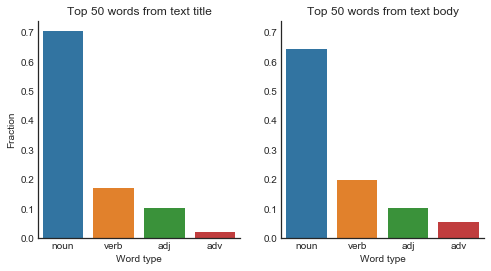

In [23]:
fig, ax = plt.subplots(1,2, figsize=(8, 4), sharey=True)
n_element = 50
sns.barplot(
    np.array(postags_key_reduced),
    np.array(norm_value_title),
    ax=ax[0])
sns.barplot(
    np.array(postags_key_body),
    np.array(norm_value_body),
    ax=ax[1])
ax[0].set_xticklabels(["noun", "verb", "adj", "adv"])
ax[0].set_title('Top 50 words from text title' )
ax[1].set_xticklabels(["noun", "verb", "adj", "adv"])
ax[1].set_title('Top 50 words from text body')
ax[0].set_ylabel('Fraction')
ax[0].set_xlabel("Word type")
ax[1].set_xlabel("Word type")

sns.despine()

## Tags similarity
### Comparison between Cosine similarity and Jaccard distance


In [24]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
selection_threshold =0.5

sim_word_cosine = defaultdict(list)
sim_word_jaccard = defaultdict(list)

for i in range(len(tags_key_reduced_quartile)):
    for j in range(len(tags_key_reduced_quartile)):
        word_i = tags_key_reduced_quartile[i]
        word_j = tags_key_reduced_quartile[j]
        
        # Porter stem to avoid matching words that have the same ending
        # such as serialization, internationalization
        word_i_lem = stemmer.stem(word_i)
        word_j_lem = stemmer.stem(word_j)
        
        # generation of trigrams
        trigrams_i = ngram(word_i_lem, 3)
        trigrams_j = ngram(word_j_lem, 3)

        cosine_sim = cosine_similarity(trigrams_i, trigrams_j)
        jaccard_sim = jaccard_distance(trigrams_i, trigrams_j)

        if cosine_sim >= selection_threshold and cosine_sim < 0.98:
            sim_word_cosine[tags_key_reduced_quartile[i]].append({
                tags_key_reduced_quartile[j]:
                cosine_sim
            })

        if jaccard_sim >= selection_threshold and jaccard_sim < 1.:
            sim_word_jaccard[tags_key_reduced_quartile[i]].append({
                tags_key_reduced_quartile[j]:
                jaccard_sim
            })

#### Use graph from network x to store associations

In [25]:
# Create a dataframe to illustrate the differences
df_tags_sim = pd.DataFrame()

for key, values in sim_word_cosine.items():
    for i in range(len(sim_word_cosine[key])):
        try:
            jaccard_entry = list(sim_word_jaccard[key][i].keys())[0]
        except IndexError:
            jaccard_entry = np.NaN

        try:
            cosine_entry = list(sim_word_cosine[key][i].keys())[0]
        except IndexError:
            cosine_entry = np.NaN
            
        df_tags_sim = df_tags_sim.append(
            {
                "TAG": key,
                "TAG_JACCARD": jaccard_entry,
                "TAG_COSINE": cosine_entry
            },
            ignore_index=True)

In [26]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# use a bidirectional graph
G_tags = nx.Graph()
node2link = zip(df_tags_sim.TAG, df_tags_sim.TAG_COSINE)
G_tags.add_nodes_from(list(df_tags_sim.TAG))
G_tags.add_edges_from(node2link)
info = nx.info(G_tags)

In [27]:
print(info)

Name: 
Type: Graph
Number of nodes: 80
Number of edges: 73
Average degree:   1.8250


In [28]:
df_tags_sim.head(10)

,TAG,TAG_COSINE,TAG_JACCARD
0,.net,asp.net,vb.net
1,.net,vb.net,NaN
2,.net,.net-3.5,NaN
3,.net,.net-2.0,NaN
4,.net,ado.net,NaN
5,java,java-ee,java-ee
6,asp.net,.net,asp.net-mvc
7,asp.net,asp.net-mvc,asp.net-ajax
8,asp.net,asp.net-ajax,NaN
9,javascript,scripting,scripting


## Bag-of-words distribution associated to a tag

### On text title

In [29]:
df_text_reduced_tokens = df_text_reduced.loc[
    :, "TITLE_LEMMATIZED"].apply(lambda x: x.split())
df_tags_title = pd.DataFrame(
    list(zip(df_tags_reduced.TAGS_MODIFIED,
             df_text_reduced_tokens))).rename(columns={
                 0: "elkey",
                 1: "elvalue"
             })

In [30]:
corpfreq_title, corpstats_title, corpora_title = freq_stats_corpora(
    df_tags_title)

In [31]:
# sort by values in descending order
sorted_corpfreq_title = defaultdict(list)
cutoff = 10

for tag, tagfreq in corpfreq_title.items():
    # only add into sorted_corpfreq if the word occurencces are>50
    if sum(list(tagfreq.values())) > cutoff:
        sorted_corpfreq_title[tag] = sorted(
            tagfreq.items(), key=itemgetter(1), reverse=True)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


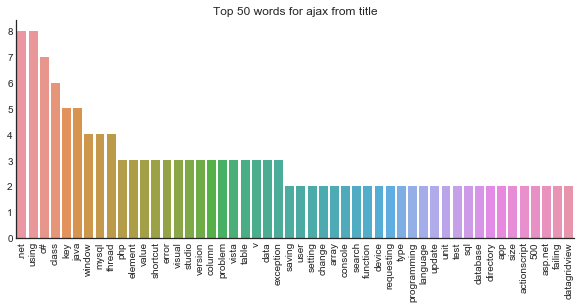

In [32]:
token_index = 10
key = list(sorted_corpfreq_title.keys())[token_index]
corptags_key_title, corptags_value_title = zip(*sorted_corpfreq_title[key])
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(corptags_key_title[:n_element]),
    np.array(corptags_value_title[:n_element]),
    ax=ax)
ax.set_xticklabels(corptags_key_title[:n_element], rotation=90)
ax.set_title('Top 50 words for %s from title' %key)
sns.despine()

### On text body

In [33]:
df_body_reduced_tokens = df_text_reduced.loc[
    :, "BODY_LEMMATIZED"].apply(lambda x: x.split())

df_tags_body = pd.DataFrame(
    list(
        zip(df_tags_reduced.TAGS_MODIFIED,
            df_body_reduced_tokens))).rename(
                columns={
                    0: "elkey",
                    1: "elvalue"
                })

In [34]:
corpfreq_body, corpstats_body, corpora_body = freq_stats_corpora(df_tags_body)

In [35]:
# sort by values in descending order
sorted_corpfreq_body = defaultdict(list)
cutoff = 1
cutoff_doc = 50
n_most_common = 20
# most frequent words will be the corpora that we use as a dictionary
most_frequent_words = defaultdict(list)

for tag, tagfreq in corpfreq_body.items():
    # only add into sorted_corpfreq if the word occurencces > cutoff_doc
    if sum(list(tagfreq.values())) > cutoff_doc:
    
        most_frequent_words[tag] = set(
            i[0] for i in tagfreq.most_common(n_most_common) if i[1] > cutoff)
        sorted_corpfreq_body[tag] = sorted(
            tagfreq.items(), key=itemgetter(1), reverse=True)


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


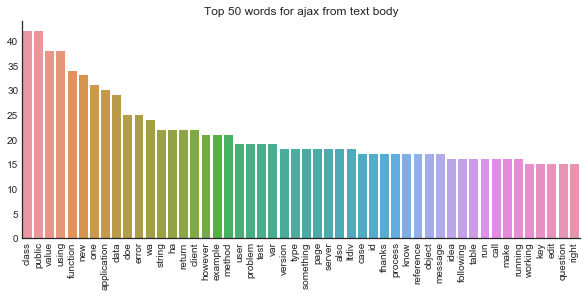

In [36]:
token_index = 10
key = list(sorted_corpfreq_body.keys())[token_index]
corptags_key_body, corptags_value_body = zip(*sorted_corpfreq_body[key])
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(corptags_key_body[:n_element]),
    np.array(corptags_value_body[:n_element]),
    ax=ax)
ax.set_xticklabels(corptags_key_body[:n_element], rotation=90)
ax.set_title(
    'Top 50 words for %s from text body' %key)
sns.despine()

__Observation__:
- From text.body and text.title, the tag words appear the most often in the word distrbution. For example, 
    - {tagword: *python*, word_distrb: {python: 280, way: 120...}
    - {tagword: *performance*, word_distrb: {performance: 120, time: 50...}
    - {tagword: *html*, word_distrb: {html: 150, page: 80...}
- This implies that we can rely on the presence of certain words to correctly predict tags

# Supervised learning: ScikitLearn OneVsRest Classifier

In [37]:
# Some flags
l_crossval = False

## Use text title +body

### Random sampling

In [38]:
df_tags_reduced_sampled = df_tags_reduced.sample(5000, random_state=2)

### Label binarization

In [39]:
from sklearn.preprocessing import MultiLabelBinarizer

lb = MultiLabelBinarizer()
targets = lb.fit_transform(df_tags_reduced_sampled.TAGS_MODIFIED)


### Train/crossval/test split
We create a corpus from the train set. This corpus contains the n most frequent words in each tag. We have seen previously that the tag is often found in the text body.

In [40]:
X_counts = df_tags_reduced_sampled.TITLE_LEMMATIZED \
            +' '+ df_tags_reduced_sampled.BODY_LEMMATIZED

# shuffle indices
idx = np.arange(X_counts.shape[0])
np.random.seed(23)
np.random.shuffle(idx)

# Generate train/crossval/test sets
train_size = int(.8 * X_counts.shape[0])

X_train = X_counts.iloc[idx[:train_size]]
y_train = targets[idx[:train_size],:]
X_test = X_counts.iloc[idx[train_size:]]
y_test = targets[idx[train_size:],:]

## Most frequent words


In [41]:
df_X_counts = X_counts.apply(lambda x: x.split())
# combine all tokens together for freq dist
X_counts_corpora = df_X_counts.sum()

### Monograms

In [42]:
X_count_freq = FreqDist(X_counts_corpora)
sorted_X_count_freq = sorted(X_count_freq.items(), key = itemgetter(1), reverse=True)
X_counts_key, X_counts_value = zip(*sorted_X_count_freq)

In [43]:
df_X_counts = pd.DataFrame(
    list(zip(X_counts_key, X_counts_value)), columns=["WORD", "FREQ"])
df_X_counts.FREQ.describe([0.8, 0.9, 0.95])

count    38110.000000
mean         8.106219
std         48.675443
min          1.000000
50%          1.000000
80%          3.000000
90%          8.000000
95%         21.000000
max       2490.000000
Name: FREQ, dtype: float64

In [44]:
df_X_counts_95 = df_X_counts[df_X_counts.FREQ>df_X_counts.FREQ.quantile(0.95)]
print("Total number of words: {}, we'll take only the top 5%: {} words".format(
    len(X_counts_key), len(df_X_counts_95)))

Total number of words: 38110, we'll take only the top 5%: 1894 words


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


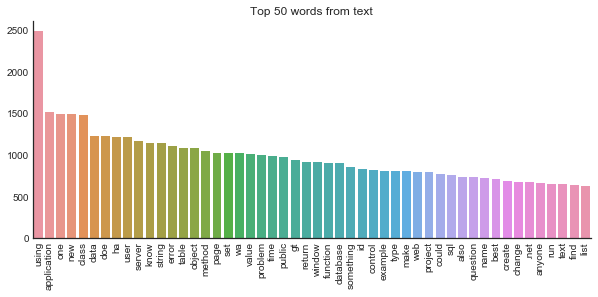

In [45]:
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(X_counts_key[:n_element]),
    np.array(X_counts_value[:n_element]),
    ax=ax)
ax.set_xticklabels(X_counts_key[:n_element], rotation=90)
ax.set_title(
    'Top 50 words from text')
sns.despine()

__Observation__:
- more than 50% of the words only have 1 occurence, we can a limit at the selection of max features. Here top 5% of the words have >= 19 occurences, we can reduce our number choice of words to the top 5%.

### Bigrams

In [46]:
from nltk import bigrams
X_count_corpora_bi = bigrams(X_counts_corpora)
X_count_freq_bi = FreqDist(X_count_corpora_bi)
sorted_X_count_freq_bi = sorted(X_count_freq_bi.items(), key = itemgetter(1), reverse=True)
X_counts_key_bi, X_counts_value_bi = zip(*sorted_X_count_freq_bi)
X_counts_join_key_bi = [" ".join(w) for w in X_counts_key_bi]

In [47]:
df_X_counts_bi = pd.DataFrame(
    list(zip(X_counts_join_key_bi, X_counts_value_bi)),
    columns=["WORD", "FREQ"])
df_X_counts_bi.FREQ.describe([0.8, 0.9, 0.95, 0.98])

count    231485.000000
mean          1.334544
std           2.068314
min           1.000000
50%           1.000000
80%           1.000000
90%           2.000000
95%           3.000000
98%           4.000000
max         299.000000
Name: FREQ, dtype: float64

In [48]:
df_X_counts_bi_98 = df_X_counts_bi[
    df_X_counts_bi.FREQ > df_X_counts_bi.FREQ.quantile(0.98)]
print("Total number of words: {}, we'll take only the top 2%: {} words".format(
    len(X_counts_join_key_bi), len(df_X_counts_bi_98)))

Total number of words: 231485, we'll take only the top 2%: 4292 words


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


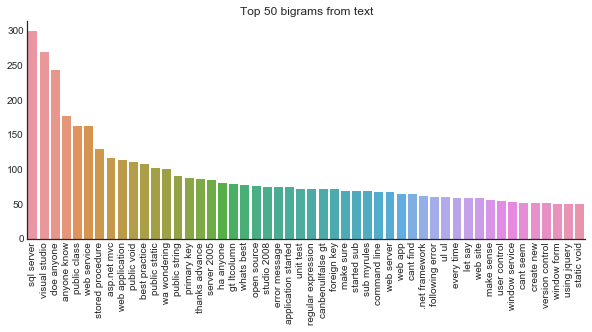

In [49]:
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(X_counts_join_key_bi[:n_element]),
    np.array(X_counts_value_bi[:n_element]),
    ax=ax)
ax.set_xticklabels(X_counts_join_key_bi[:n_element], rotation=90)
ax.set_title(
    'Top 50 bigrams from text')
sns.despine()

### Trigrams

In [50]:
from nltk import trigrams
X_count_corpora_tri = trigrams(X_counts_corpora)
X_count_freq_tri = FreqDist(X_count_corpora_tri)
sorted_X_count_freq_tri = sorted(X_count_freq_tri.items(), key = itemgetter(1), reverse=True)
X_counts_key_tri, X_counts_value_tri = zip(*sorted_X_count_freq_tri)
X_counts_join_key_tri = [" ".join(w) for w in X_counts_key_tri]

In [51]:
df_X_counts_tri = pd.DataFrame(
    list(zip(X_counts_join_key_tri, X_counts_value_tri)),
    columns=["WORD", "FREQ"])
df_X_counts_tri.FREQ.describe([0.8, 0.9, 0.95, 0.98])

count    293590.000000
mean          1.052236
std           0.600468
min           1.000000
50%           1.000000
80%           1.000000
90%           1.000000
95%           1.000000
98%           2.000000
max         138.000000
Name: FREQ, dtype: float64

In [52]:
df_X_counts_tri_98 = df_X_counts_tri[
    df_X_counts_tri.FREQ > df_X_counts_tri.FREQ.quantile(0.98)]
print("Total number of words: {}, we'll take only the top 2%: {} words".format(
    len(X_counts_join_key_tri), len(df_X_counts_tri_98)))

Total number of words: 293590, we'll take only the top 2%: 2175 words


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


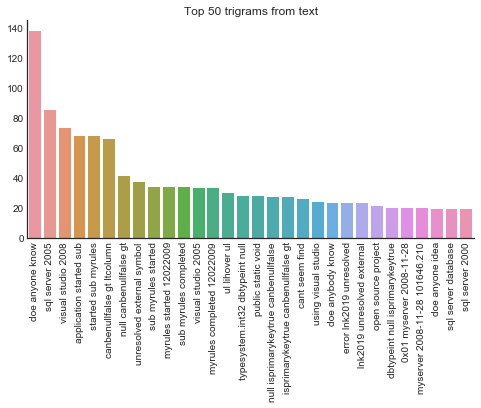

In [53]:
fig, ax = plt.subplots(figsize=(8, 4))
n_element = 30
sns.barplot(
    np.array(X_counts_join_key_tri[:n_element]),
    np.array(X_counts_value_tri[:n_element]),
    ax=ax)
ax.set_xticklabels(X_counts_join_key_tri[:n_element], rotation=90)
ax.set_title(
    'Top 50 trigrams from text')
sns.despine()

### Training with Dummy Classifier (strategy=prior)
__Count vectorizer__ 

In [54]:
def tokenize(text):
    return text.split(' ')

params_vectorizer = {'max_features': len(df_X_counts_95), 
                     'tokenizer' :tokenize, 'lowercase':False}

In [55]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import jaccard_similarity_score
from sklearn.feature_extraction.text import CountVectorizer

Dummy_pipeline_count = Pipeline([
    ('count', CountVectorizer(**params_vectorizer)),
    ('clf', OneVsRestClassifier(DummyClassifier(strategy='prior'))),
])

Dummy_pipeline_count.fit(X_train, y_train)
# compute the testing accuracy
y_pred_count_dummy = Dummy_pipeline_count.predict(X_test)
y_pred_proba_count_dummy = Dummy_pipeline_count.predict_proba(X_test)
y_pred_new_count_dummy = get_best_tags(y_pred_count_dummy,
                                       y_pred_proba_count_dummy, n_tags=5)
score_dummy_count = evaluate(
    y_test,
    y_pred_new_count_dummy,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_dummy_count))

Test score: 0.12


__Tfidf vectorizer__ 

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

Dummy_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(**params_vectorizer)),
    ('clf', OneVsRestClassifier(DummyClassifier(strategy='prior'))),
])

Dummy_pipeline_tfidf.fit(X_train, y_train)
# compute the testing accuracy
y_pred_tfidf_dummy = Dummy_pipeline_tfidf.predict(X_test)
y_pred_proba_tfidf_dummy = Dummy_pipeline_tfidf.predict_proba(X_test)
y_pred_new_tfidf_dummy = get_best_tags(y_pred_tfidf_dummy,
                                       y_pred_proba_tfidf_dummy, n_tags=5)
score_dummy_tfidf = evaluate(
    y_test,
    y_pred_new_tfidf_dummy,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_dummy_tfidf))

Test score: 0.12


### Training with Naive Bayes Classifier
__Count vectorizer__ 

In [57]:
from sklearn.naive_bayes import MultinomialNB

NB_pipeline_count = Pipeline([
    ('count', CountVectorizer(**params_vectorizer)),
    ('clf', OneVsRestClassifier(
        MultinomialNB(fit_prior=True, class_prior=None))),
])

NB_pipeline_count.fit(X_train, y_train)
# compute the testing accuracy
y_pred_count = NB_pipeline_count.predict(X_test)
y_pred_proba_count = NB_pipeline_count.predict_proba(X_test)
y_pred_new_count = get_best_tags(y_pred_count, y_pred_proba_count)

score_nb_count, errors_count = evaluate(
    y_test,
    y_pred_new_count,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=True,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_nb_count))

Test score: 0.39


__Tfidf vectorizer__

In [58]:
NB_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(**params_vectorizer)),
    ('clf', OneVsRestClassifier(
        MultinomialNB(fit_prior=True, class_prior=None))),
])

NB_pipeline_tfidf.fit(X_train, y_train)
# compute the testing accuracy
y_pred_tfidf = NB_pipeline_tfidf.predict(X_test)
y_pred_proba_tfidf = NB_pipeline_tfidf.predict_proba(X_test)
y_pred_new_tfidf = get_best_tags(y_pred_tfidf, y_pred_proba_tfidf)

score_nb_tfidf, errors_tfidf = evaluate(
    y_test,
    y_pred_new_tfidf,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=True,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_nb_tfidf))

Test score: 0.24


### Training with SVM
__Count vectorizer__

In [59]:
from sklearn.svm import SVC

best_params = {"kernel":"linear"}
# cross validation
if l_crossval:
    params_classifier =  {"C": np.logspace(-2, 1, 4)}
    crossval = CrossValidation(
    OneVsRestClassifier(SVC(**best_params)),
    CountVectorizer(**params_vectorizer), params_classifier,
    lb,
    G_tags)
    crossval.cv(X_train, y_train)
    
    best_params["C"] = crossval.best_parameter_["C"]["value"]
    print("Best parameter", crossval.best_parameter_)
    
else:
    best_params["C"] = 1.
    
SVM_pipeline_count = Pipeline([
    ('count', CountVectorizer(**params_vectorizer)),
    ('clf',
     OneVsRestClassifier(SVC(**best_params))),
])


SVM_pipeline_count.fit(X_train, y_train)
y_pred_svm_count = SVM_pipeline_count.predict(X_test)
y_pred_proba_svm_count = SVM_pipeline_count.decision_function(X_test)
y_pred_new_svm_count = get_best_tags(y_pred_svm_count, y_pred_proba_svm_count)

score_svm_count = evaluate(
    y_test,
    y_pred_new_svm_count,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_svm_count))

Test score: 0.41


__Tfidf vectorizer__

In [60]:
# cross validation
best_params = {"kernel":"linear"}
if l_crossval:
    params_classifier =  {"C": np.logspace(-2, 1, 4)}
    crossval_tfidf = CrossValidation(
        OneVsRestClassifier(SVC(**best_params)),
        TfidfVectorizer(**params_vectorizer), params_classifier,
        lb,
        G_tags)
    crossval_tfidf.cv(X_train, y_train)
    best_params["C"] = crossval.best_parameter_["C"]["value"]
    print("Best parameter", crossval_tfidf.best_parameter_)

else:
    best_params["C"] = 1.
    
SVM_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(**params_vectorizer)),
    ('clf',
     OneVsRestClassifier(SVC(**best_params))),
])

SVM_pipeline_tfidf.fit(X_train, y_train)
y_pred_svm_tfidf = SVM_pipeline_tfidf.predict(X_test)
y_pred_proba_svm_tfidf = SVM_pipeline_tfidf.decision_function(X_test)
y_pred_new_svm_tfidf = get_best_tags(y_pred_svm_tfidf, y_pred_proba_svm_tfidf)

score_svm_tfidf = evaluate(
    y_test,
    y_pred_new_svm_tfidf,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_svm_tfidf))

Test score: 0.50


In [169]:
## Examples
n_sample = 10
test_index = np.arange(y_test.shape[0])
np.random.seed(42)
np.random.shuffle(test_index)

for i in test_index[:n_sample]:
    y_lb_pred = lb.inverse_transform(y_pred_new_svm_tfidf[i].reshape(1,-1))
    y_lb_test = lb.inverse_transform(y_test[i].reshape(1,-1))
    print("y_true: ",y_lb_test,", y_pred:",y_lb_pred)

y_true:  [('sql', 'sql-server')] , y_pred: [('sql',)]
y_true:  [('browser', 'silverlight')] , y_pred: [('silverlight',)]
y_true:  [('c#', 'design-patterns', 'winforms')] , y_pred: [('c#',)]
y_true:  [('css', 'javascript')] , y_pred: [('javascript',)]
y_true:  [('sql', 'sql-server')] , y_pred: [('sql-server',)]
y_true:  [('xml', 'xsd')] , y_pred: [('xml',)]
y_true:  [('datetime', 'sql')] , y_pred: [('sql',)]
y_true:  [('actionscript-3', 'html', 'regex', 'string')] , y_pred: [('regex',)]
y_true:  [('asp.net-mvc', 'jquery')] , y_pred: [('javascript', 'jquery')]
y_true:  [('model-view-controller', 'php')] , y_pred: [('php',)]


## Training with Logistic Regression

__Count vectorizer__

In [61]:
from sklearn.linear_model import LogisticRegressionCV

lr_pipeline_count = Pipeline([
    ('count', CountVectorizer(**params_vectorizer)),
    ('clf',
     OneVsRestClassifier(
         LogisticRegressionCV(
             Cs=np.logspace(-2, 2, 5), dual=True, cv=5, solver='liblinear'))),
])

lr_pipeline_count.fit(X_train, y_train)
y_pred_lr_count = lr_pipeline_count.predict(X_test)
y_pred_proba_lr_count = lr_pipeline_count.decision_function(X_test)
y_pred_new_lr_count = get_best_tags(y_pred_lr_count, y_pred_proba_lr_count)

score_lr_count = evaluate(
    y_test,
    y_pred_new_lr_count,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_lr_count))

Test score: 0.45


__Tfidf vectorizer__

In [62]:
lr_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(**params_vectorizer)),
    ('clf',
     OneVsRestClassifier(
         LogisticRegressionCV(
             Cs=np.logspace(-2, 2, 5), dual=True, cv=5, solver='liblinear'))),
])

lr_pipeline_tfidf.fit(X_train, y_train)
y_pred_lr_tfidf = lr_pipeline_tfidf.predict(X_test)
y_pred_proba_lr_tfidf = lr_pipeline_tfidf.decision_function(X_test)
y_pred_new_lr_tfidf = get_best_tags(y_pred_lr_tfidf, y_pred_proba_lr_tfidf)

score_lr_tfidf = evaluate(
    y_test,
    y_pred_new_lr_tfidf,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_lr_tfidf))

Test score: 0.44


## Summary table

In [63]:
vectorizer = 4 * ["COUNT", "TFIDF"]
model = 2 * ["NAIVE BAYES"] + 2*["LOG REG"] +2*["SVM"]+2* ["DUMMY"]

test_score = [
    score_nb_count,
    score_nb_tfidf,
    score_lr_count,
    score_lr_tfidf,
    score_svm_count,
    score_svm_tfidf,
    score_dummy_count,
    score_dummy_tfidf,
]

df_summary = pd.DataFrame(
    list(zip(model, vectorizer, test_score)),
    columns=["MODEL", "VECTORIZER",
             "AVG F1 SCORE"]).set_index(["MODEL", "VECTORIZER"])
df_summary

AVG F1 SCORE
MODEL       VECTORIZER              
NAIVE BAYES COUNT           0.388280
            TFIDF           0.238333
LOG REG     COUNT           0.448811
            TFIDF           0.443171
SVM         COUNT           0.412426
            TFIDF           0.503417
DUMMY       COUNT           0.120796
            TFIDF           0.120796

__Observation__:
- SVM with TFIDF vectorizer returns the best test score so far (0.47). 
- Logistic regressions are not bad either.

## Study of performance vs ngrams

In [143]:
n_gram_list = [(1,1), (2,2), (3,3), (1,2), (2,3), (1,3)]
max_features = 2500
best_params = {'C': 1, 'kernel':'linear'}
n_grams_score = []

for n_gram in n_gram_list:
    # cross validation
    params_vectorizer = {
        "max_features": max_features,
        "ngram_range": n_gram,
        'tokenizer' :tokenize, 
        'lowercase':False
    }

    SVM_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(**params_vectorizer)),
        ('clf', OneVsRestClassifier(SVC(**best_params))),
    ])

    SVM_pipeline.fit(X_train, y_train)
    y_pred_svm = SVM_pipeline.predict(X_test)
    y_pred_proba_svm = SVM_pipeline.decision_function(X_test)
    y_pred_new_svm = get_best_tags(y_pred_svm, y_pred_proba_svm)

    score_svm = evaluate(
        y_test,
        y_pred_new_svm,
        binarizer=lb,
        G_tags=G_tags,
        l_print_errors=False,
        l_deduplication=True)

    print('Test score: {0:.2f}'.format(score_svm))
    n_grams_score.append(score_svm)

Test score: 0.51
Test score: 0.23
Test score: 0.05
Test score: 0.51
Test score: 0.23
Test score: 0.51


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


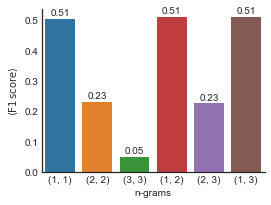

In [144]:
fig, ax = plt.subplots(figsize=(4,3))
sns.barplot(
    np.arange(len(n_gram_list)),
    np.array(n_grams_score),
    ax=ax)
for p in ax.patches:
    ax.annotate(
        np.round(p.get_height(), decimals=2),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        xytext=(0, 1),
        textcoords='offset points')
ax.set_xticklabels(n_gram_list)
ax.set_ylabel(r"$\left<\mathrm{F1\, score}\right>$")
ax.set_xlabel("n-grams")
sns.despine()

__Observation__:
- with monograms, we attain the highest average F1 score, it is unnecessary to build bigrams or trigrams

## Study of performance vs max features

In [179]:
max_features_list = np.logspace(2, 4, 8 , dtype=int)

In [180]:
max_features_list 

array([  100,   193,   372,   719,  1389,  2682,  5179, 10000])

In [66]:
max_features_list = np.logspace(2, 4, 8 , dtype=int)
best_params = {'C': 1., 'kernel': 'linear'}
max_features_score = []

for max_feature in max_features_list:
    # cross validation
    params_vectorizer = {"max_features": max_feature, 
                         "ngram_range": (1, 2),
                         'tokenizer' :tokenize, 
                         'lowercase':False}

    SVM_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(**params_vectorizer)),
        ('clf', OneVsRestClassifier(SVC(**best_params))),
    ])

    SVM_pipeline.fit(X_train, y_train)
    y_pred_svm = SVM_pipeline.predict(X_test)
    y_pred_proba_svm = SVM_pipeline.decision_function(X_test)
    y_pred_new_svm = get_best_tags(y_pred_svm, y_pred_proba_svm)

    score_svm = evaluate(
        y_test,
        y_pred_new_svm,
        binarizer=lb,
        G_tags=G_tags,
        l_print_errors=False,
        l_deduplication=True)

    print('Test score: {0:.2f}'.format(score_svm))
    max_features_score.append(score_svm)

Test score: 0.20
Test score: 0.31
Test score: 0.37
Test score: 0.44
Test score: 0.49
Test score: 0.52
Test score: 0.52
Test score: 0.52


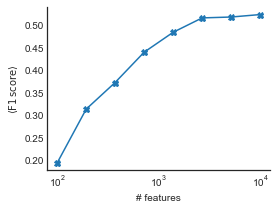

In [145]:
fig, ax = plt.subplots(figsize=(4,3))
ax.semilogx(max_features_list,  max_features_score, marker="X")
ax.set_ylabel(r"$\left<\mathrm{F1\, score}\right>$")
ax.set_xlabel("# features")
sns.despine()

__Observation__:
- the performance saturates when we approach high number of features. From 1390 features onwards, the test score attains 0.49.

# Unsupervised learning: Rate of Perplexity Change (RPC) and LDA
Using the novel metric RPC defined by RPC(i) = |(P_i-P_i-1)/(t_i-t_i-1)|, where P represents the perplexity and t the number of topics, this overcomes weaknesses on the selection of an appropriate number of topics in LDA modelling based on only the perplexity measure (it is less stable because it depends on seeds)

Rather than choosing among several numbers of topics over a potentially large range where perplexity fluctuates, the quantity defined as the changepoint of rate of perplexity change can be chosen as to be the most appropriate number of topics from a heuristic analysis.

Ref: Zhao et al. BMC Bioinformatics 2015, 16(Suppl 13):S8 http://www.biomedcentral.com/1471-2105/16/S13/S8

## Dimensionality reduction using truncated SVD
Using SVD (Singular Value Decomposition) to determine the maximum features to be included in Count Vectorizer

In [192]:
from sklearn.decomposition import TruncatedSVD

# Prep text body
X_body = df_text[["TITLE_LEMMATIZED", "BODY_LEMMATIZED"]].apply(
    lambda x: ' '.join(x) if pd.notnull(x["TITLE_LEMMATIZED"]) else x["BODY_LEMMATIZED"],
    axis=1)

n_components = 2750
params_vectorizer = {
    "max_features": 5000,
    "ngram_range": (2, 2),
    'tokenizer': tokenize,
    'lowercase': False
}
count_vect = CountVectorizer(**params_vectorizer)
svd = TruncatedSVD(n_components=n_components)

X_body_vect = count_vect.fit_transform(X_body)
X_body_svd = svd.fit_transform(X_body_vect)
X_body_cumsum = np.cumsum(svd.explained_variance_ratio_)

With 2750 components, 90.6% of the data is retained.


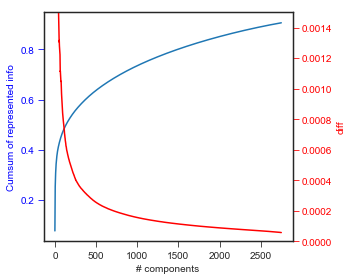

In [193]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(np.arange(n_components),  X_body_cumsum )
ax.tick_params('y', colors='b')
ax.set_xlabel("# components")
ax.set_ylabel("Cumsum of represented info", color='b')
ax2 = ax.twinx()
ax2.plot(np.arange(1, n_components), np.diff(X_body_cumsum), color='red')
ax2.tick_params('y', colors='r')
ax2.set_ylim(0,0.0015)
ax2.set_ylabel("diff", color='r')
plt.tight_layout()
sns.set_style('ticks')

print("With %d components, %.1f%% of the data is retained."%(n_components, 100*X_body_cumsum[-1]))

__Observation__:
- with SVD, we observe that with 2500 components, we retain 90% of the data, therefore we can choose to have a lower number of max features.

## Build LDA

__Count Vectorizer__

In [194]:
n_chosen_components = 2750
params_vectorizer = {"max_features": n_chosen_components, "ngram_range": (1, 1),
                     'tokenizer' :tokenize, 'lowercase':False}
count_vect = CountVectorizer(**params_vectorizer)
X_LDA = count_vect.fit_transform(X_body)

from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file =X_body.str.split(" ").as_matrix()
word2vec_output_file = 'word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

import numpy as np
np.random.seed(13)

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

import gensim

In [199]:
from sklearn.decomposition import LatentDirichletAllocation

num_cv = 3
num_topics = np.linspace(100,400,6, dtype=int)
perplexities = [[] for x in range(len(num_topics))]
ldas2 = [[] for x in range(len(num_topics))]

for i in range(len(num_topics)):
    for cv in range(num_cv):
        print("%d: processing num topic %d " % (cv, num_topics[i]))
        lda = LatentDirichletAllocation(
            n_components=num_topics[i],
            max_iter=10,
            learning_method='online',
            learning_offset=50.,
            #random_state=0)
            total_samples=5000)

        ldas2[i].append(lda.fit(X_LDA))
        perplexities[i].append(lda.perplexity(X_LDA))

rpc2 = rpc_score(np.array(perplexities), np.array(num_topics))

0: processing num topic 100 
1: processing num topic 100 
2: processing num topic 100 
0: processing num topic 160 
1: processing num topic 160 
2: processing num topic 160 
0: processing num topic 220 
1: processing num topic 220 
2: processing num topic 220 
0: processing num topic 280 
1: processing num topic 280 
2: processing num topic 280 
0: processing num topic 340 
1: processing num topic 340 
2: processing num topic 340 
0: processing num topic 400 
1: processing num topic 400 
2: processing num topic 400 


In [307]:
new_x = np.arange(100,400,10)
new_y = np.interp(new_x, num_topics, np.mean(perplexities, axis=-1))

from scipy.interpolate import interp1d
f = interp1d(num_topics, np.mean(perplexities, axis=-1), kind='cubic' )

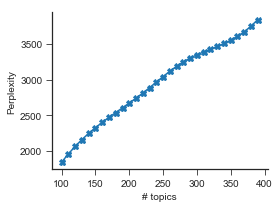

In [308]:
sns.set_style('ticks')
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.plot(new_x, f(new_x) , marker="X")
ax.set_xlabel("# topics")
ax.set_ylabel("Perplexity")
sns.despine()
plt.tight_layout()

In [309]:
rpc2 = np.absolute((f(new_x)[1:] - f(new_x)[:-1]) / (new_x[1:] - new_x[:-1]))

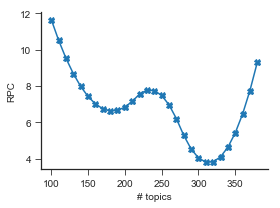

In [311]:
sns.set_style('ticks')
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.plot(new_x[:-1], rpc2, marker="X")
ax.set_xlabel("# topics")
ax.set_ylabel("RPC")
sns.despine()
plt.tight_layout()
#fig.savefig("RPC.pdf")

In [337]:
tf_feature_names = count_vect.get_feature_names()
opt_lda_model = ldas2[4][0]
df_top_words = pd.DataFrame(opt_lda_model.components_, columns=tf_feature_names)

## Baseline model
__Attribution of topic label__ 
- attributed by looking at the top 10 word distribution of each topic, then retain the highest occurence word that matches with provided tags (tags_key_reduced_quartile) in the corpora, if no match is found, choose he highest occurence noun.

In [373]:
words = [[] for i in range(df_top_words.shape[0])]
Hs = dict()
n_top = 100
num_keep_words = 10

for k in df_top_words.index:
    df_top_words_sorted = df_top_words.loc[k].sort_values(ascending=False)
    H = H_entropy(df_top_words_sorted.values)
    Hs[k] = H

    for word in df_top_words_sorted[:n_top].index:
        
        if word in set(tags_key_reduced_quartile):
            words[k].append(word)
    
    # default values
    if not words[k]:
        words[k] = ['c++']  
        #df_top_words_sorted[:num_keep_words].index.tolist()

index_Hs_neg = [k for k, v in Hs.items() if v < 0]
dict_topicnames = defaultdict(list)
topicnames = []

# arrays for significant topics only
for idx, word in enumerate(np.array(words)[index_Hs_neg]):
    groupword = ','.join(word)
    dict_topicnames[index_Hs_neg[idx]].append(groupword)
    topicnames.append(groupword)

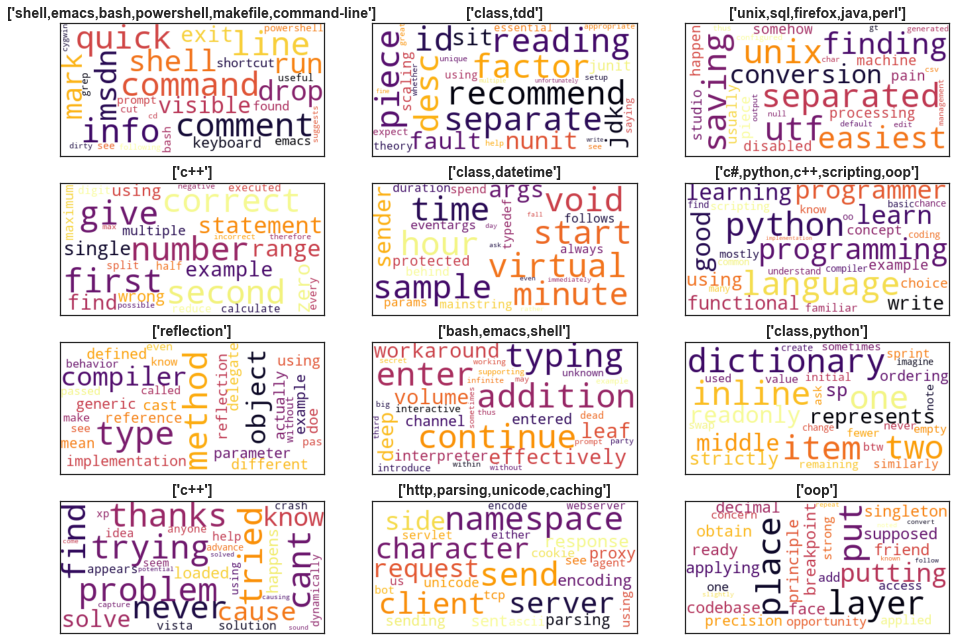

In [374]:
from wordcloud import WordCloud
sns.set_style('white')

n_top = 30
fig, axes = plt.subplots(4, 3, figsize=(14, 9))
ax = axes.flatten()
i = 0

for k in df_top_words.loc[index_Hs_neg].sample(12,random_state=42).index:
    # take relative word frequencies into account, lower max_font_size
    df_top_words_sorted = df_top_words.loc[k].sort_values(ascending=False)
    wordcloud = WordCloud(
        background_color="white",
        max_words=n_top,
        max_font_size=50,
        colormap="inferno",
        relative_scaling=.2).generate(' '.join(
            df_top_words_sorted[:n_top].index))

    ax[i].imshow(wordcloud, interpolation="bilinear")
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
    ax[i].set_title("%s" % dict_topicnames[k], fontsize=14, fontweight="bold")

    i += 1

plt.tight_layout(w_pad=-4., h_pad=1)
#fig.savefig("topics_word_cloud.pdf")

__Observation__:
- some of the topics are well attributed, some not really.
    - architecture, shell, design, java, syntax, algorithm, django and database are coherent with the topic word distribution
    - string, sorting are incoherent with the word distribution
    - topics class appear twice 

In [378]:
# Create Document - Topic Matrix

lda_output = opt_lda_model.transform(X_LDA)[:, index_Hs_neg]
#num_topics = opt_lda_model.n_components
# column names
#topicnames = ["Topic" + str(i) for i in range(num_topics)]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(
    np.round(lda_output, 2), columns=topicnames, index=X_body.index)

def potential_tags(data):
    #pdb.set_trace()
    sorted_data = sorted(data.items(), key=itemgetter(1), reverse=True)
    tags_temp = [k.split(',') for k,v in sorted_data if v>=0.1]

    # if no tags have a value above the threshold, take the top topic
    if len(tags)<1:
        tags_temp = [k.split(',') for k,v in sorted_data[0][0]]
        
    # set is used to avoid redundancy
    tags = list(set([item for sublist in tags_temp for item in sublist]))
    return tags

# Get dominant topic for each document
#dominant_topic = np.array(topicnames)[np.argmax(
#    df_document_topic.values, axis=1)]
#kwds = {'threshold':0.1, 'max_tags':1}
dominant_topic = df_document_topic.apply(potential_tags,axis=1)
df_text.loc[df_document_topic.index, 'POTENTIAL_TAGS'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)


def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)


# Apply Style
#df_document_topics = df_document_topic.sample(
#    10, random_state=293).style.applymap(color_green).applymap(make_bold)


In [379]:
df_text_reduced_LDA = pd.merge(
    df_tags_reduced_sampled,
    pd.DataFrame(df_text['POTENTIAL_TAGS']),
    left_index=True,
    right_index=True)

In [380]:
df_text_reduced_LDA[["BODY", "TAGS", "POTENTIAL_TAGS"]].sample(
    10, random_state=42)

,BODY,TAGS,POTENTIAL_TAGS
Id,,,
536132,<p>I'm building a custom RTE that converts use...,"[javascript, internet-explorer, wysiwyg, rte]","[firefox, c++, browser]"
525711,<p>It's been a couple of years since I last wo...,"[c#, java, java-ee]","[java, reflection]"
404899,<p>I found the following rather strange. Then ...,"[c#, functional-programming, delegates, lambda...",[reflection]
348210,<p>What firefox plugins could you not live wit...,[firefox],"[firefox, spring, logging, ajax]"
222410,<p>The company I work for has several clients....,"[.net-3.5, .net-2.0, development-environment]","[dll, soap, parsing, automation, installer, ca..."
246058,<p>I got this error when trying to update an i...,"[c#, exception, invoke]",[c++]
134615,<p>I've been searching on SO on how to do i18n...,"[c#, internationalization]","[c#,python,c++,scripting,oop]"
552047,<p>When analyzing traffic with a packet sniffe...,"[http, weblogic, http-post]","[parsing, apache, unicode, http, caching]"
239544,<p>I like to generate a thread dump programmat...,"[java, debugging, thread-dump]","[c++, java, spring, logging]"


In [381]:
y_true_lda = lb.transform(df_text_reduced_LDA.TAGS_MODIFIED)
y_pred_lda = lb.transform(df_text_reduced_LDA.POTENTIAL_TAGS)

KeyError: 'xaml,debugging'

In [319]:
score_lda = evaluate(
        y_true_lda,
        y_pred_lda,
        binarizer=lb,
        G_tags=G_tags,
        l_print_errors=False,
        l_deduplication=True)
print('Test score: {0:.2f}'.format(score_lda))

Test score: 0.12


In [323]:
df_text_reduced_LDA.loc[239544]["BODY"]

'<p>I like to generate a thread dump programmatically. I\'ve learned that there a basically two ways to do it:</p>\n\n<ol>\n<li>Use the "Java Virtual Machine Tool Interface" JVM-TI</li>\n<li>Use the higher abstracted "Java Debugger Interface" JDI</li>\n</ol>\n\n<p>For the JVM-TI I was able to find some useful information, but I would have to write a JNI-DLL which, at least for the moment, I would like to avoid. With the JDI I can use Java and it seems I\'m able to use it from within the application. But I wasn\'t able to find some kind of tutorial or HOWTO for it. The only documentation I could find, were the Java-Docs <a href="http://java.sun.com/j2se/1.5.0/docs/guide/jpda/jdi/" rel="noreferrer">http://java.sun.com/j2se/1.5.0/docs/guide/jpda/jdi/</a> which isn\'t very helpful, because it doesn\'t show me how to use this classes.</p>\n\n<p>So, does anybody know of a good tutorial/book I could read?</p>\n\n<p>Thx for any help!</p>\n'

In [324]:
df_text_reduced_LDA.loc[239544]["TAGS_MODIFIED"]

['java', 'debugging']

In [370]:
df_text_reduced_LDA.loc[222410]["POTENTIAL_TAGS"]

['process, configuration, dll, deployment, installation, installer, msbuild',
 'debugging, unicode, sql, automation, ide, soap, sorting']

In [333]:
len(topicnames), len(set(topicnames))

(110, 81)

In [334]:
'python' in topicnames

False